# Uncertainty Estimation of Transformer Predictions

In this notebook, we will experiment with UE for misclassification and out-of-distribution (OOD) detection in text classification and sequence-to-sequence tasks. We evaluate the ELECTRA model on the MRPC dataset and explore several popular and state-of-the-art methods for uncertainty estimation (UE) - Softmax Response (SR or MaxProb), MC dropout, Mahalanobis distance (MD), Robust Density Estimation (RDE), and Hybrid UQ (HUQ). \
Then, we train and evaluate the DistilBERT model on the CLINC dataset with 150 classes and explore these UE methods for OOD detection in text classification. \
Finally, we evaluate the BART model for abstractive text summarization using the same state-of-the-art methods for OOD detection in sequence-to-sequence tasks.

In [ ]:
!pip install transformers==4.30.2 datasets==2.15.0 accelerate>=0.20.1
!pip install omegaconf==2.3.0
!pip install rouge_score

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3ffbeddfe53e176af20ab7f14ede57ddf408655230fee665cdb9a01960683ea5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


# Classification

## Toy Example

Let's start with the simple example on the Two Moons dataset and visualize model prediction and UE for this task. Here we will use the fully-connect layers in the model with residual connection and spectral normalization.

In [ ]:
import torch
import random, os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from scipy.stats import rankdata
from sklearn.preprocessing import KBinsDiscretizer

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
class FCResNet(torch.nn.Module):
    def __init__(
        self,
        input_dim=2,
        features=128,
        depth=4,
        spectral_normalization=True,
        coeff=0.95,
        n_power_iterations=1,
        activation='relu',
        dropout_rate=0.01
    ):
        super().__init__()

        self.first = torch.nn.Linear(input_dim, features)
        self.residuals = torch.nn.ModuleList(
            [torch.nn.Linear(features, features) for i in range(depth)]
        )
        self.dropout = torch.nn.Dropout(dropout_rate)

        if spectral_normalization:
            self.first = torch.nn.utils.spectral_norm(
                self.first, n_power_iterations=n_power_iterations
            )

            for i in range(len(self.residuals)):
                self.residuals[i] = torch.nn.utils.spectral_norm(
                    self.residuals[i],
                    n_power_iterations=n_power_iterations,
                )
        self.last = torch.nn.Linear(features, 2)
        self.activation = torch.nn.ReLU()


    def forward(self, x):
        x = self.first(x)
        for residual in self.residuals:
            x = x + self.dropout(self.activation(residual(x)))
        self.feature = x
        x = self.last(x)
        return x

def fit_model(model, train_dataloader, criterion, optimizer, n_epochs = 150):
    model.train()
    for epoch in range(n_epochs):
        for it, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()
        if (epoch+1)%10 == 0:
            print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    model.eval()
    return model

In [ ]:
def make_data(total_size=5000, centers=np.array([[-4.0, -4.0], [0.0, 4.0]]), seed=42, noise=0.1):
    X, y = datasets.make_moons(n_samples=total_size, shuffle=True, noise=noise, random_state=seed)
    return X, y

def plot_ax(plt, xx, yy, ue, title, row_start=0, row_end=2, col_start=0, col_end=2):
    kb = KBinsDiscretizer(n_bins=100, encode='ordinal')
    ue_kb = kb.fit_transform(ue.reshape(-1, 1))
    ue_kb = np.clip(ue_kb, -1, 60)

    ax = plt.subplot(gs[row_start:row_end, col_start:col_end])
    ax.set_title(title)
    ax.contourf(xx, yy, ue_kb.reshape(*xx.shape), levels=15, cmap=cmap)
    ax.axis('off')
    return ax

(-1.2373171643476994, 1.7849766056363756)

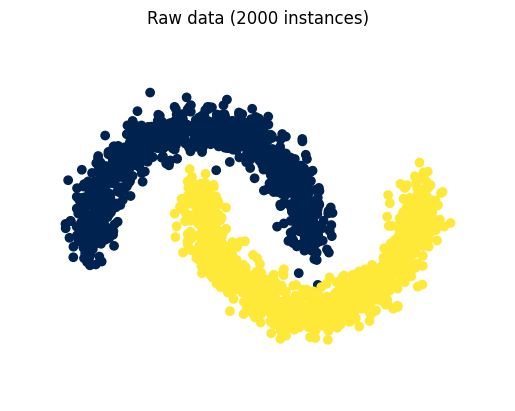

In [ ]:
dataset_size = 2_000
cmap = 'cividis'

X_train, y_train = make_data(
    total_size=dataset_size, seed=42
)

x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5

h_x, h_y = [0.05] * 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
X_test = np.c_[xx.ravel(), yy.ravel()]

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
plt.axis('off')
plt.title(f"Raw data ({dataset_size} instances)")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

In [ ]:
seed_everything(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_torch = torch.Tensor(X_train).to(device)
X_test_torch = torch.Tensor(X_test).to(device)

y_train_torch = torch.Tensor(y_train).to(device)
y_train_torch = y_train_torch.long()

train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_dataloader = DataLoader(train_dataset, batch_size=128)

model = FCResNet().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model = fit_model(model, train_dataloader, criterion, optimizer)

Epoch 9: train loss: 0.1506330519914627
Epoch 19: train loss: 0.06841453164815903
Epoch 29: train loss: 0.027694469317793846
Epoch 39: train loss: 0.0190952830016613
Epoch 49: train loss: 0.009763067588210106
Epoch 59: train loss: 0.00922725535929203
Epoch 69: train loss: 0.007612531539052725
Epoch 79: train loss: 0.005038008559495211
Epoch 89: train loss: 0.006586222909390926
Epoch 99: train loss: 0.0034410711377859116
Epoch 109: train loss: 0.005178504623472691
Epoch 119: train loss: 0.005149202886968851
Epoch 129: train loss: 0.002627167385071516
Epoch 139: train loss: 0.0028827860951423645
Epoch 149: train loss: 0.004505871795117855


In [ ]:
from scipy.special import softmax

train_preds = model(X_train_torch)
train_features = model.feature

preds = model(X_test_torch)
features = model.feature

probs = softmax(preds.detach().cpu().numpy(), axis=-1)

### Softmax Response (SR)

Trivial baseline for UE a trained model that uses the probabilities generated via the output softmax layer of the neural network. The smaller this maximum probability is, the more uncertain model is:
$$u_{SR} = 1 - \max_{c \in C} p(y=c|x),$$\
where $p(y=c|x)$ - probability of of sample $x$ belong to class $y=c\in C$

Yonatan Geifman and Ran El-Yaniv. 2017. [Selective classification for deep neural networks](https://proceedings.neurips.cc/paper/2017/hash/4a8423d5e91fda00bb7e46540e2b0cf1-Abstract.html). Advances in Neural Information Processing Systems, 30:4878–4887.

In [ ]:
sr = 1 - np.max(probs, axis=-1)

### Mahalanobis Distance (MD)

Mahalanobis distance is a generalisation of the Euclidean distance, which takes into account the spreading of instances in the training set along various directions in a feature space. We estimate uncertainty by measuring the Mahalanobis distance between a test instance and the closest class-conditional Gaussian distribution:
$$u_{MD} = \min_{c \in C}(h_{i}-\mu_{c})^{T}\Sigma^{-1}(h_{i}-\mu_{c}),$$\
where $h_{i}$ is a hidden representation of a $i$-th instance, $\mu_{c}$ is a centroid of a class $c$, and $\Sigma$ is a covariance matrix for hidden representations of training instances.


Kimin Lee, Kibok Lee, Honglak Lee, and Jinwoo Shin. 2018. [A simple unified framework for detecting outof-distribution samples and adversarial attacks](https://proceedings.neurips.cc/paper/2018/hash/abdeb6f575ac5c6676b747bca8d09cc2-Abstract.html). In Advances in Neural Information Processing Systems 31: Annual Conference on Neural Information Processing Systems 2018, NeurIPS 2018, December 3-8, 2018, Montréal, Canada, volume 31, pages 7167–7177.

In [ ]:
def compute_centroids(train_features, train_labels):
    centroids = []
    for label in np.sort(np.unique(train_labels)):
        centroids.append(train_features[train_labels == label].mean(axis=0))
    return np.asarray(centroids)


def compute_covariance(centroids, train_features, train_labels):
    cov = np.zeros((train_features.shape[1], train_features.shape[1]))
    for c, mu_c in tqdm(enumerate(centroids)):
        for x in train_features[train_labels == c]:
            d = (x - mu_c)[:, None]
            cov += d @ d.T
    return cov / train_features.shape[0]


def mahalanobis_distance(train_features, train_labels, eval_features):
    centroids = compute_centroids(train_features, train_labels)
    sigma = compute_covariance(centroids, train_features, train_labels)
    diff = eval_features[:, None, :] - centroids[None, :, :]
    try:
        sigma_inv = np.linalg.inv(sigma)
    except:
        sigma_inv = np.linalg.pinv(sigma)
    dists = np.matmul(np.matmul(diff, sigma_inv), diff.transpose(0, 2, 1))
    dists = np.asarray([np.diag(dist) for dist in dists])
    return np.min(dists, axis=1)

In [ ]:
md = mahalanobis_distance(train_features.detach().cpu().numpy(), y_train, features.detach().cpu().numpy())

0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


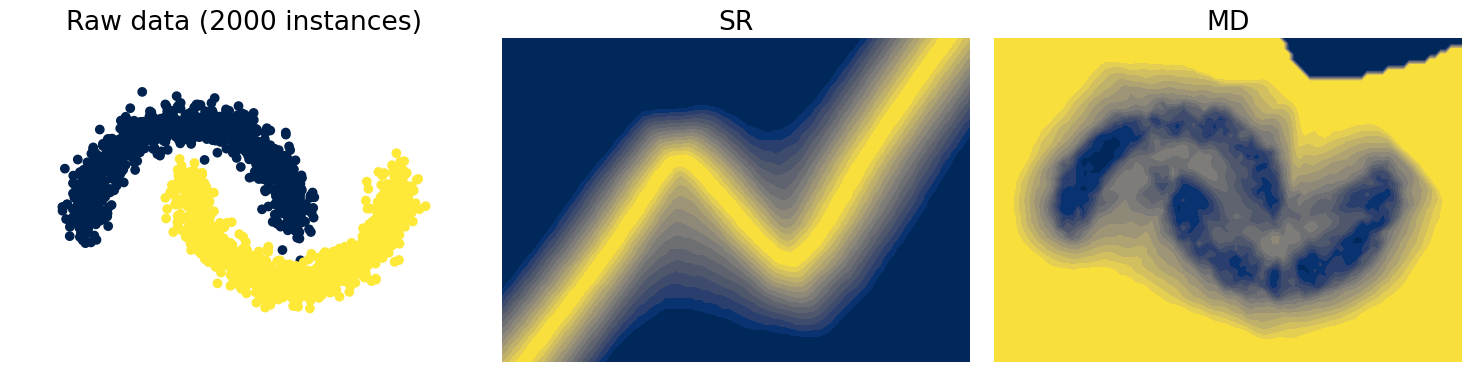

In [ ]:
from matplotlib import gridspec

plt.rcParams.update({"font.size": 16})
fig = plt.figure(figsize=(15, 4))
gs = gridspec.GridSpec(2, 6)

ax = plt.subplot(gs[:2, :2])
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
ax.axis('off')
ax.set_title(f"Raw data ({dataset_size} instances)")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plot_ax(plt, xx, yy, sr, 'SR', row_start=0, row_end=2, col_start=2, col_end=4)
plot_ax(plt, xx, yy, md, 'MD', row_start=0, row_end=2, col_start=4, col_end=6)

plt.tight_layout()
plt.show()

In our illustrative example of the two moons dataset, the state-of-the-art epistemic UE methods, MD, separate the ID area from the remaining feature space well.
However, the middle area between the two classes is marked with high confidence, yet for SR this area is marked as highly uncertain due to the presence of instances with high aleatoric uncertainty.

## Text Misclassification Detection

Machine learning methods are naturally prone to errors as they typically have to deal with ambiguous, noisy, and incomplete data during both training and inference. Since mistakes are inevitable, it is crucial to understand whether model predictions can be trusted or not and abstain from unreliable decisions. For this purpose, we would like to perform Uncertainty estimation (UE) of model predictions aimed to solve this task. Ideally, uncertain instances should correspond to erroneous objects and help in misclassification detection. If the model might return a prediction with high uncertainty it is desirable to delegate decisions to a human expert or a more advanced model, which increases the overall quality of decision-making.

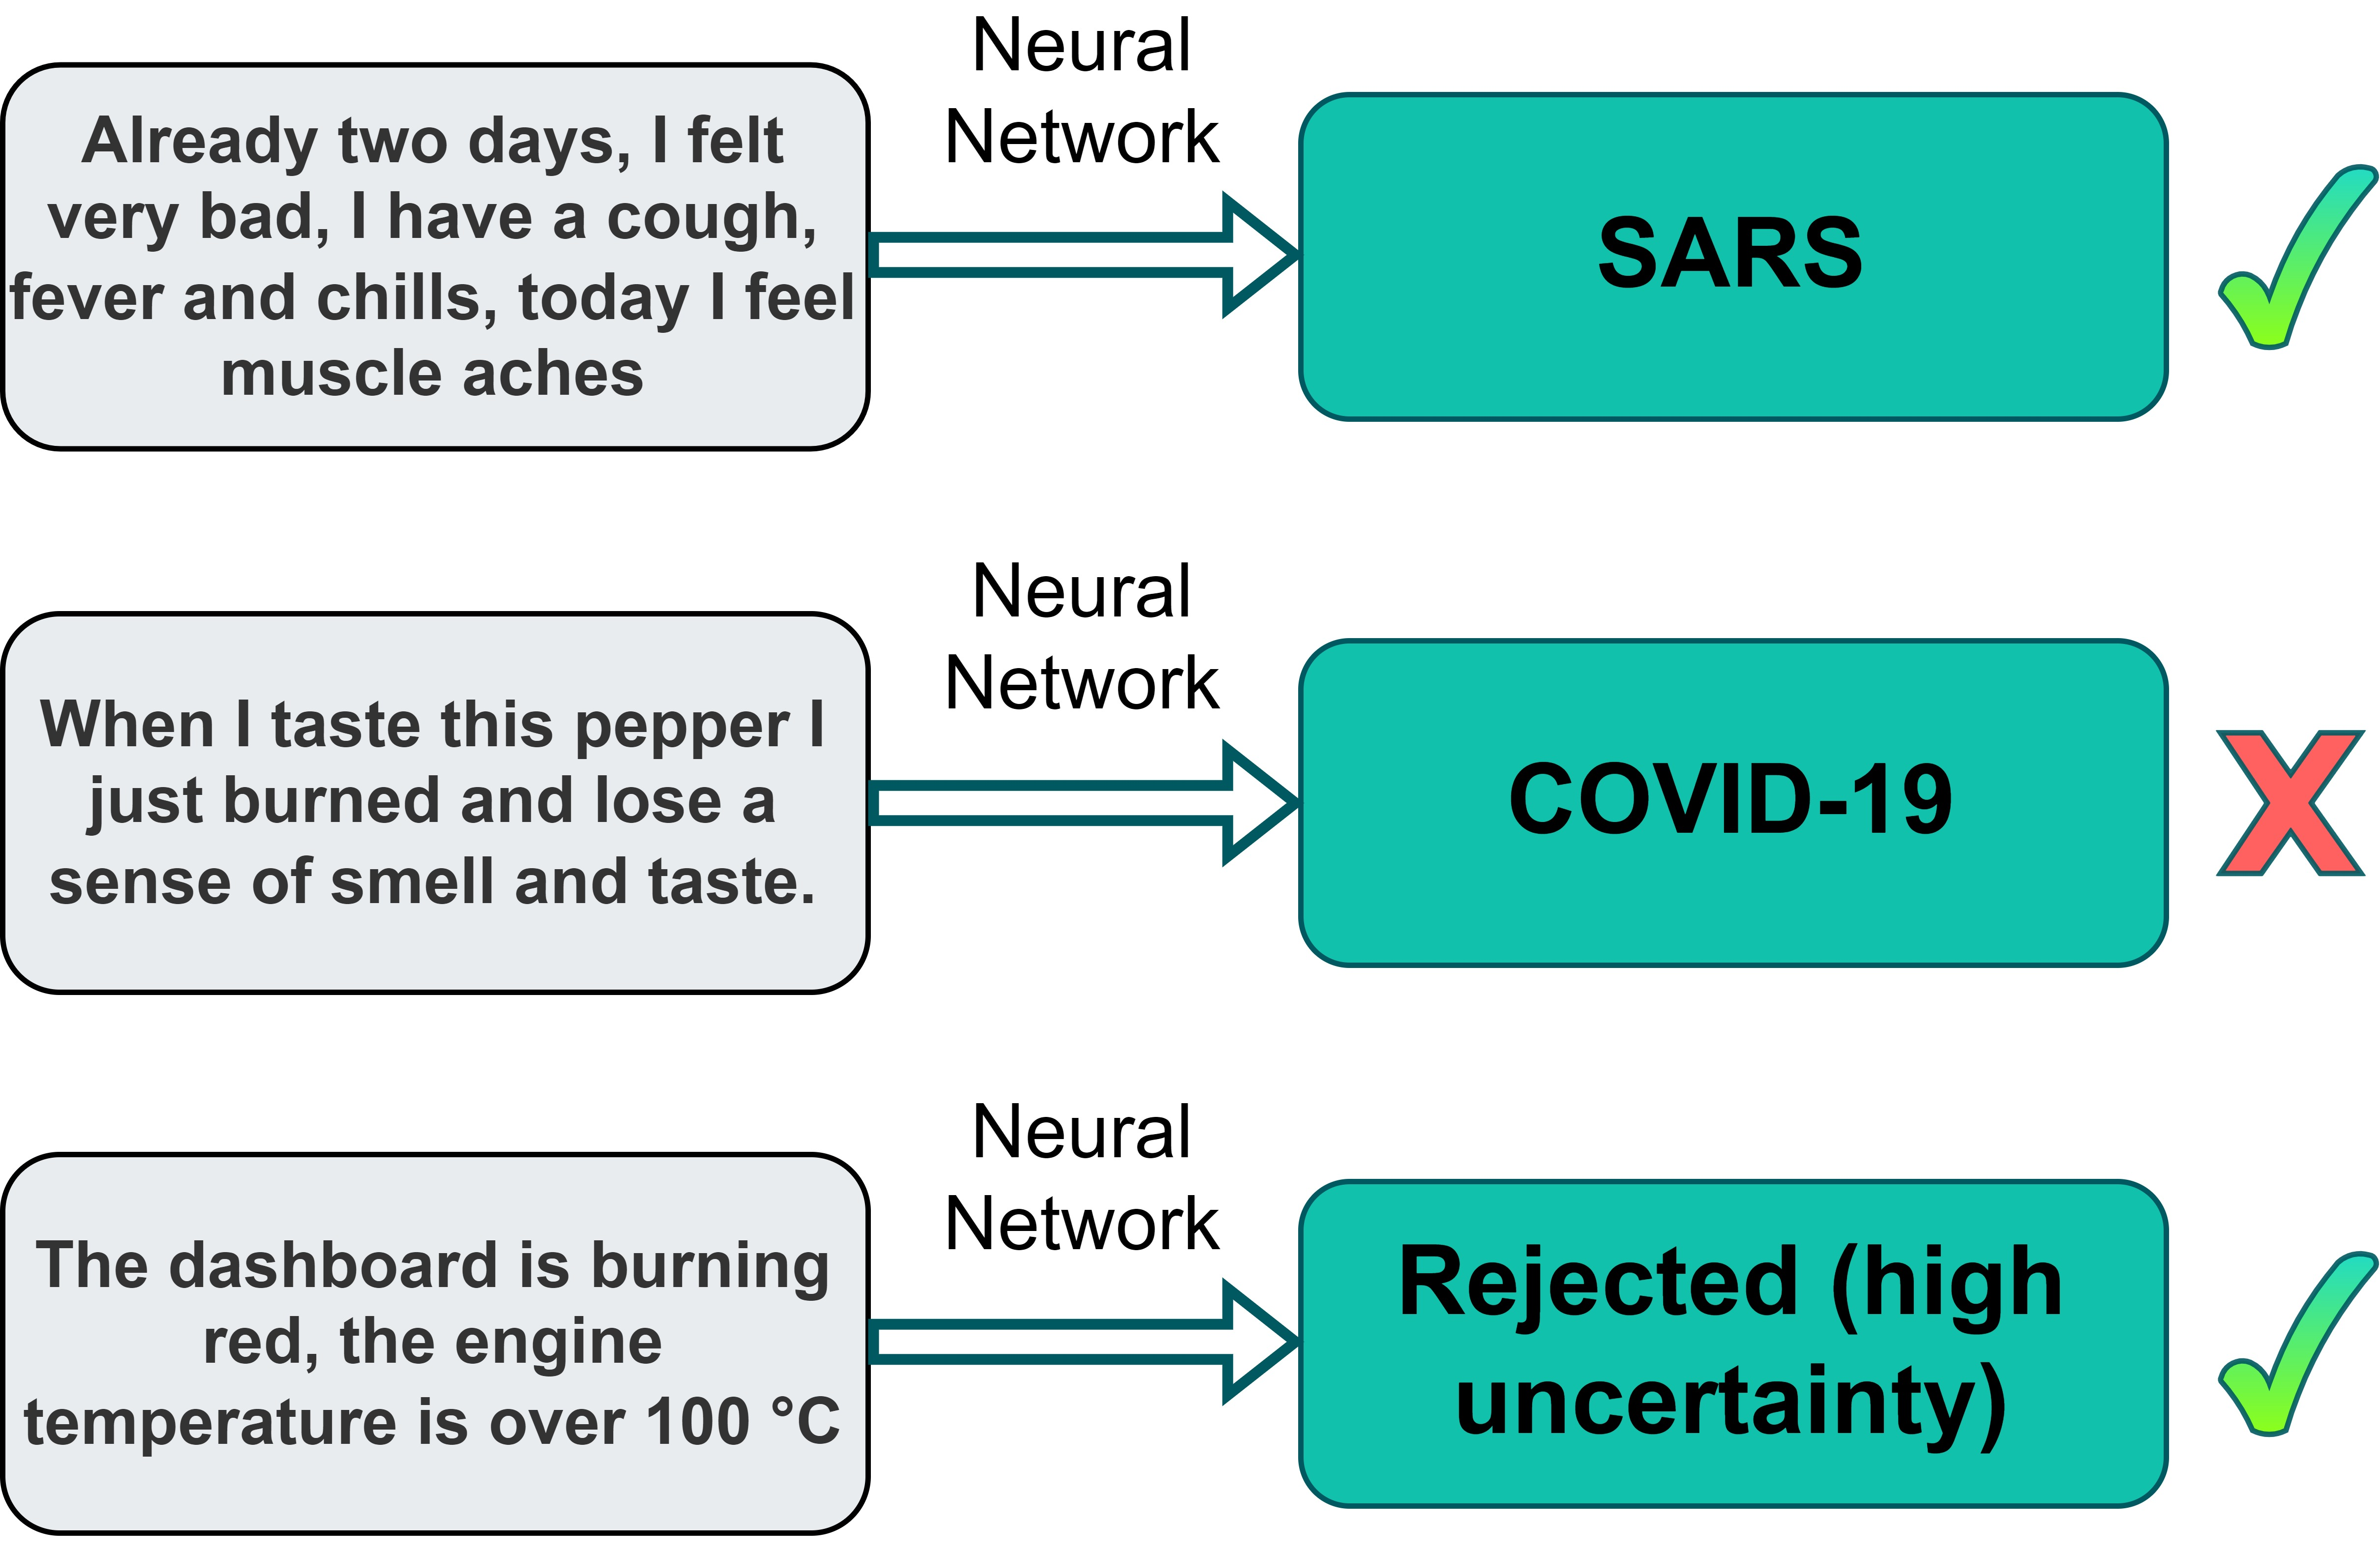

Here we will use Microsoft Research Paraphrase Corpus (MRPC) dataset. MRPC is a corpus consisting of 5,801 sentence pairs collected from newswire articles. Each pair is labeled if it is a paraphrase or not by human annotators. The whole set is divided into a training subset (4,076 sentence pairs of which 2,753 are paraphrases) and a test subset (1,725 pairs of which 1,147 are paraphrases).

William B. Dolan and Chris Brockett. 2005. [Automatically constructing a corpus of sentential paraphrases](https://aclanthology.org/I05-5002/). In Proceedings of the Third International Workshop on Paraphrasing (IWP2005).


In [ ]:
from datasets import load_metric, load_dataset, Dataset

datasets = load_dataset("glue", "mrpc")

print(datasets['train'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0}


We will use the ELECTRA small model from the HuggingFace, which is already fine-tuned for this task.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Intel/electra-small-discriminator-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("Intel/electra-small-discriminator-mrpc")

print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/54.3M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [ ]:
def preprocess_function(
    label_to_id, sentence1_key, sentence2_key, tokenizer, max_seq_length, examples
):
    # Tokenize the texts
    args = (
        (examples[sentence1_key],)
        if sentence2_key is None
        else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(
        *args, padding="max_length", max_length=max_seq_length, truncation=True
    )

    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [
            (label_to_id[l] if l != -1 else -1) for l in examples["label"]
        ]
    return result

In [ ]:
sentence1_key, sentence2_key = ("sentence1", "sentence2")
max_seq_length = 128

label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
label_list = datasets["train"].features["label"].names
label_to_id = {i: v for i, v in enumerate(label_list)}

f_preprocess = lambda examples: preprocess_function(
    label_to_id, sentence1_key, sentence2_key, tokenizer, max_seq_length, examples
)

datasets = datasets.map(
    f_preprocess,
    batched=True,
    load_from_cache_file=False,
)

train_dataset = datasets['train']
eval_dataset = datasets['validation']

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

### General Inference

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=None,
)

results = trainer.predict(eval_dataset)

In [ ]:
from scipy.special import softmax
from sklearn.metrics import classification_report

probs = softmax(results.predictions, axis=1)
preds = probs.argmax(-1)
labels = results.label_ids

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.86      0.64      0.73       129
           1       0.85      0.95      0.90       279

    accuracy                           0.85       408
   macro avg       0.85      0.80      0.82       408
weighted avg       0.85      0.85      0.85       408



### Calculating UE

#### Softmax Response (SR)

In [ ]:
sr = 1 - np.max(probs, axis=-1)

#### MC Dropout

Recently, it was shown that dropout, a well-known regularization technique, is formally equivalent to approximate variational inference in a deep Gaussian process if it is activated during prediction. This method, known as Monte Carlo (MC) dropout, uses the approximating variational distribution with Bernoulli variables related to network units. MC dropout does not impose any overhead during training, introduces no additional parameters, and thus does not require any additional memory. The main disadvantage of this method is that it usually requires many forward-pass samplings for approximating predictive posterior, which makes it also computationally expensive.

Yarin Gal and Zoubin Ghahramani. 2016. [Dropout as a bayesian approximation: Representing model uncertainty in deep learning](https://proceedings.mlr.press/v48/gal16.html). In Proceedings of The 33rd International Conference on Machine Learning, volume 48 of Proceedings of Machine Learning Research, pages 1050–1059, New York, New York, USA. PMLR

Now we implement custom dropout layer and functions for replacing all model dropouts to our custom version.

In [ ]:
class DropoutMC(torch.nn.Module):
    def __init__(self, p: float, activate=False):
        super().__init__()
        self.activate = activate
        self.p = p
        self.p_init = p

    def forward(self, x: torch.Tensor):
        return torch.nn.functional.dropout(
            x, self.p, training=self.training or self.activate
        )

In [ ]:
def convert_dropouts(model, inference_prob=0.1):
    """This function replace all model dropouts with custom dropout layer."""
    dropout_ctor = lambda p, activate: DropoutMC(
        p=inference_prob, activate=False
    )
    convert_to_mc_dropout(model, {"Dropout": dropout_ctor, "StableDropout": dropout_ctor})

In [ ]:
def convert_to_mc_dropout(
    model, substitution_dict
):
    for i, layer in enumerate(list(model.children())):
        proba_field_name = "dropout_rate" if "flair" in str(type(layer)) else "p"
        module_name = list(model._modules.items())[i][0]
        layer_name = layer._get_name()
        proba_field_name = "drop_prob" if layer_name == "StableDropout" else proba_field_name #DeBERTA case
        if layer_name in substitution_dict.keys():
            model._modules[module_name] = substitution_dict[layer_name](
                p=getattr(layer, proba_field_name), activate=False
            )
        else:
            convert_to_mc_dropout(model=layer, substitution_dict=substitution_dict)


def activate_mc_dropout(
    model: torch.nn.Module, activate: bool, random: float = 0.0, verbose: bool = False
):
    for layer in model.children():
        if isinstance(layer, DropoutMC):
            if verbose:
                print(layer)
                print(f"Current DO state: {layer.activate}")
                print(f"Switching state to: {activate}")
            layer.activate = activate
            if activate and random:
                layer.p = random
            if not activate:
                layer.p = layer.p_init
        else:
            activate_mc_dropout(
                model=layer, activate=activate, random=random, verbose=verbose
            )

Convert all dropout layers to MC Dropout and activate them.

In [ ]:
convert_dropouts(model)
activate_mc_dropout(model, activate=True)

In [ ]:
model

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): DropoutMC()
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): DropoutMC()
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=256, out_features=2

Repeat inference *committee_size* times with activated dropout and save all probabilities for estimating uncertainty.

In [ ]:
from tqdm.notebook import tqdm

committee_size = 20
eval_passes = False

eval_results = {}
eval_results["sampled_probabilities"] = []
eval_results["sampled_answers"] = []

for i in tqdm(range(committee_size)):
    res = trainer.predict(datasets["validation"])

    logits_i = res.predictions
    preds_i = logits_i.argmax(-1)
    probs_i = softmax(logits_i, axis=1)

    eval_results["sampled_probabilities"].append(probs_i.tolist())
    eval_results["sampled_answers"].append(preds_i.tolist())

    if eval_passes:
        print(classification_report(labels, preds))

activate_mc_dropout(model, activate=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Consider we have conducted $T$ stochastic forward passes with activated dropout. We can use the following ways to quantify uncertainty with methods based on MC dropout:

1\. Sampled maximum probability (SMP) is:
\begin{equation}
u_{\text{SMP}} = 1 -  \max_{c \in C} \frac{1}{T}\sum_{t=1}^T  p_t^{c} ,
\end{equation}
where $p^{c}_t$ is the probability of the class $c$ for the $t$-th stochastic forward pass.

In [ ]:
def sampled_max_prob(sampled_probabilities):
    mean_probabilities = np.mean(sampled_probabilities, axis=1)
    top_probabilities = np.max(mean_probabilities, axis=-1)
    return 1 - top_probabilities

smp = sampled_max_prob(np.array(eval_results['sampled_probabilities']).transpose(1, 0, 2))

2\. Probability variance (PV) is:
\begin{equation}
u_{\text{PV}} = \frac{1}{C} \sum_{c = 1}^C \left( \frac{1}{T} \sum_{t = 1}^T {(p^c_t-\overline{p^c})^2} \right),
\end{equation}
where $\overline{p^c}=\frac{1}{T} \sum_t{p^{c}_{t}}$ is the probability for a class $c$ averaged across $T$ stochastic forward passes.

In [ ]:
def probability_variance(sampled_probabilities, mean_probabilities=None):
    if mean_probabilities is None:
        mean_probabilities = np.mean(sampled_probabilities, axis=1)

    mean_probabilities = np.expand_dims(mean_probabilities, axis=1)

    return ((sampled_probabilities - mean_probabilities) ** 2).mean(1).sum(-1)

pv = probability_variance(np.array(eval_results['sampled_probabilities']).transpose(1, 0, 2))

3\. Bayesian active learning by disagreement (BALD) is:
\begin{equation}
%\begin{array}{l}
u_{\text{BALD}} = -\sum_{c = 1}^C \overline{p^c} \log \overline{p^c} +  \frac{1}{T}\sum_{c, t} p^{c}_{t}\log p^{c}_{t}.
%\end{array}
\end{equation}

In [ ]:
def entropy(x):
    return np.sum(-x * np.log(np.clip(x, 1e-8, 1)), axis=-1)

def bald_func(sampled_probabilities):
    predictive_entropy = entropy(np.mean(sampled_probabilities, axis=1))
    expected_entropy = np.mean(entropy(sampled_probabilities), axis=1)

    return predictive_entropy - expected_entropy

bald = bald_func(np.array(eval_results['sampled_probabilities']).transpose(1, 0, 2))

The two former techniques are specifically designed for estimation of the epistemic (model) uncertainty arising from the lack of knowledge and ignore the aleatoric uncertainty related to ambiguity and noise in the data, while the latter method can be seen as a measure of total uncertainty.

#### Mahalanobis Distance (MD)

We will change the classification head of the model to extract features from the penultimate layer from the head. To produce better UE, we can apply spectral normalization for this layer. However, it requires fine-tuning the model with spectral normalization and extracting features only after that.

A. Vazhentsev et al., [Uncertainty Estimation of Transformer Predictions for Misclassification Detection](https://aclanthology.org/2022.acl-long.566/), in Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), 2022, pp. 8237–8252.

In [ ]:
# This is a liitle modified ELECTRA head, we will use it for extracting model's features.
class ElectraClassificationHeadIdentityPooler(torch.nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, other):
        super().__init__()
        self.dropout1 = other.dropout
        self.dense = other.dense

    def forward(self, features):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout1(x)
        x = self.dense(x)
        return x

In [ ]:
model.classifier = ElectraClassificationHeadIdentityPooler(model.classifier)

eval_labels = [example["label"] for example in eval_dataset]
eval_dataset = eval_dataset.remove_columns("label")

train_labels = np.asarray([example["label"] for example in train_dataset])
train_dataset = train_dataset.remove_columns("label")

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=None,
)
res_eval = trainer.predict(eval_dataset)
res_train = trainer.predict(train_dataset)

eval_results["mahalanobis_distance"] = mahalanobis_distance(
    res_train.predictions, train_labels, res_eval.predictions
)

0it [00:00, ?it/s]

#### Hybrid Uncertainty Quantification (HUQ)

We combine aleatoric and epistemic uncertainty in a single score, which we call **Hybrid UQ (HUQ)**. Consider we have a training dataset $\mathcal{D}$.

  We define $\mathcal{D}_{\text{ID}} = \{x \in \mathcal{D}\colon U_{\text{E}}(x) \leq \delta_{\min}\}$ as in-distribution instances from $\mathcal{D}$;
  $X_{\text{ID}} = \{x\colon U_{\text{E}}(x) \leq \delta_{\min}\}$ as arbitrary in-distribution instances; $X_{\text{IDA}} = \{x {\in X_{\text{ID}}}\colon U_{\text{A}}(x) > \delta_{\max}\}$ as ambiguous in-distribution instances (instances that lie on the discriminative border of the trained classifier). Here, $\delta_{\min}$, $\delta_{\max}$ are thresholds selected on the validation dataset. Consider we are given measures of aleatoric $U_{\text{A}}(x)$ and epistemic $U_{\text{E}}(x)$ uncertainty.

  To make different UE scores comparable, we define a ranking function $R(u, \mathfrak{D})$ as a rank of $u$ over a sorted dataset $\mathfrak{D}$, where $u_1 > u_2$ implies $R(u_1, \mathfrak{D}) > R(u_2, \mathfrak{D})$. For a given measure of aleatoric and epistemic uncertainty, we compute total uncertainty $U_{\text{T}}(x)$ as a linear combination $U_{\text{T}}(x) = \!\!(1 - \alpha) R(U_{\text{E}}(x), D) + \alpha R(U_{\text{A}}(x), D)$, where $\alpha$ is a hyperparameter selected on the validation dataset.
  
Thus, the uncertainty score for $x$ computed by HUQ is
\begin{equation*}
    U_{\text{HUQ}}(x)
    =
    \begin{cases}
      R(U_{\text{A}}(x), D_{\text{ID}}), \forall x \in X_{\text{ID}} \setminus X_{\text{AID}}, \\
      R(U_{\text{A}}(x), D),  \forall x \in X_{\text{AID}}, \\
      (1 - \alpha) R(U_{\text{E}}(x), D) + \alpha R(U_{\text{A}}(x), D), \forall x \notin X_{\text{ID}}.
    \end{cases}
\end{equation*}

\\
Artem Vazhentsev, Gleb Kuzmin, Akim Tsvigun, Alexander Panchenko, Maxim Panov, Mikhail Burtsev, and Artem Shelmanov. 2023. [Hybrid Uncertainty Quantification for Selective Text Classification in Ambiguous Tasks](https://aclanthology.org/2023.acl-long.652/). In Proceedings of the 61st Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pages 11659–11681, Toronto, Canada. Association for Computational Linguistics.

In [ ]:
def total_uncertainty_huq(epistemic, aleatoric, threshold_min=0.1, threshold_max=0.9, alpha=0.1):
    n_preds = len(aleatoric)
    n_lowest = int(n_preds*threshold_min)
    n_max = int(n_preds*threshold_max)

    aleatoric_rank = rankdata(aleatoric)
    epistemic_rank = rankdata(epistemic)

    total_rank = np.zeros_like(epistemic)

    total_rank = (1-alpha)*epistemic_rank+alpha*aleatoric_rank
    total_rank[epistemic_rank <= n_lowest] = rankdata(aleatoric[epistemic_rank <= n_lowest])
    total_rank[(aleatoric_rank > n_max) & (epistemic_rank <= n_lowest)] = aleatoric_rank[(aleatoric_rank > n_max) & (epistemic_rank <= n_lowest)]

    return total_rank

In [ ]:
eval_results["HUQ-MD"] = total_uncertainty_huq(eval_results["mahalanobis_distance"], sr, 0.1, 0.9, 0.2)

### Results

For selective classification (or misclassification detection), given a classifier $h(x)$ and uncertainty measure $U(x)$, low certainty predictions are rejected and deferred to alternate procedures, e.g., human review.
The AUC-RC indicates a dependence of the cumulative sum of misclassification loss $l_i = L(h(x_i), y_i)$ from the uncertainty rate $\theta$ used for rejection in the ascending order. Lower values of AUC-RC indicate better performance. The curve is drawn by computing the coverage ($\gamma(\theta)$) and selective risk ($r(\theta$)).
\begin{equation}
\begin{cases}
  \gamma(\theta) = \frac{1}{|D|}\sum_{(x_i, y_i) \in D} {q_i}, \\
  r(\theta) = \frac{\sum_{(x_i, y_i) \in D} {q_i} l_i}{\sum_{(x_i, y_i) \in D} {q_i}},
\end{cases}
\end{equation}
where $q_i = \mathbf{1}[U(x_i) < \theta]$.

Ran El-Yaniv and Yair Wiener. 2010. [On the foundations of noise-free selective classification.](http://portal.acm.org/citation.cfm?id=1859904) J. Mach. Learn. Res., 11:1605–1641.


In [ ]:
def rcc_auc(conf, risk, return_points=False):
    # risk-coverage curve's area under curve
    n = len(conf)
    cr_pair = list(zip(conf, risk))
    cr_pair.sort(key=lambda x: x[0], reverse=True)

    cumulative_risk = [cr_pair[0][1]]
    for i in range(1, n):
        cumulative_risk.append(cr_pair[i][1] + cumulative_risk[-1])

    points_x = []
    points_y = []

    auc = 0
    for k in range(n):
        auc += cumulative_risk[k] / (1 + k)
        points_x.append((1 + k) / n)  # coverage
        points_y.append(cumulative_risk[k] / (1 + k))  # current avg. risk

    if return_points:
        return auc, points_x, points_y
    else:
        return auc

In [ ]:
errors = (eval_labels != preds).astype(int)

results = {
    "SR": [rcc_auc(-sr, errors)],
    "SMP": [rcc_auc(-smp, errors)],
    "PV": [rcc_auc(-pv, errors)],
    "BALD": [rcc_auc(-bald, errors)],
    "MD": [rcc_auc(-eval_results["mahalanobis_distance"], errors)],
    "HUQ-MD": [rcc_auc(-eval_results["HUQ-MD"], errors)],
}

pd.DataFrame(results, index = ['RC-AUC'])

,SR,SMP,PV,BALD,MD,HUQ-MD
RC-AUC,25.56277,22.872134,21.532111,21.137154,23.054266,22.895999


As one can see, MC dropout with an BALD score shows quite good performance but requires a lot of computational time. The best single method is BALD, which shows good results. We can outperform MD with HUQ which leverages MD and SR but requires selecting hyperparameters on the validation set.

## Out-Of-Distribution Detection

In this task, we assume, that uncertain instances should correspond to out-of-distribution objects. If the model might return a prediction with high uncertainty it is desirable to delegate decisions to a human expert or reject from prediction, which increases the overall quality of decision-making.

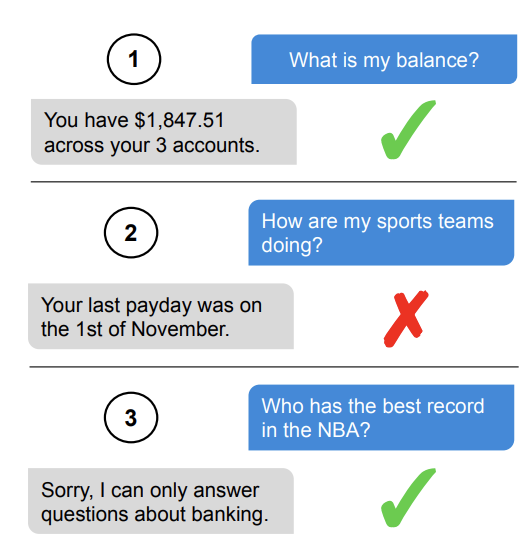

For experiments with OOD detection, we use the CLINC dataset for multi-class intent classification. The dataset includes both in-domain and out-of-distribution data. Here we will use the same scope of UE methods.

Larson, S.; Mahendran, A.; Peper, J. J.; Clarke, C.; Lee, A.; Hill, P.; Kummerfeld, J. K.; Leach, K.; Laurenzano, M. A.; Tang, L.; and Mars, J. 2019a. [An Evaluation Dataset for Intent Classification and Out-of-Scope Prediction.](https://aclanthology.org/D19-1131/) In Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJC)

In [ ]:
from datasets import load_metric, load_dataset, Dataset

datasets = load_dataset("clinc_oos", 'plus')
def map_classes(examples):
    examples["labels"] = (
        examples["labels"] if (examples["labels"] < 42) else examples["labels"] - 1
    )
    return examples

datasets = datasets.rename_column("intent", "labels")

#remove label 42 from the training and validation sets, since it corresponds to the OOD label
for split in ['train', 'validation']:
    datasets[split] = datasets[split].filter(lambda x: x["labels"] != 42)

    datasets[split] = datasets[split].map(
        map_classes,
        batched=False,
    )

print(datasets['train'][0])

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'text': 'what expression would i use to say i love you if i were an italian', 'labels': 60}


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=150)

print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
sentence1_key, sentence2_key = ("text", None)
max_seq_length = 128

label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
label_list = datasets["train"].features["labels"].names
label_to_id = {i: v for i, v in enumerate(label_list)}

f_preprocess = lambda examples: preprocess_function(
    label_to_id, sentence1_key, sentence2_key, tokenizer, max_seq_length, examples
)

datasets = datasets.map(
    f_preprocess,
    batched=True,
    load_from_cache_file=False,
)

train_dataset = datasets['train']
dev_dataset = datasets['validation']
eval_dataset = datasets['test']

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

### Model Training

Fine-tune our model on the dataset with only ID labels.

In [ ]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric
import os

accuracy_score = load_metric("accuracy")

def compute_metrics(metric, p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    result = metric.compute(predictions=preds, references=p.label_ids)
    if len(result) > 1:
        result["combined_score"] = np.mean(list(result.values())).item()

    return result

metric_fn = lambda p: compute_metrics(accuracy_score, p)

os.environ["WANDB_DISABLED"] = "true"
DEVICE = 'cuda'
training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  logging_strategy="epoch",
                                  seed=42,
                                  learning_rate=5e-5,
                                  weight_decay=1e-1,
                                  num_train_epochs=3,
                                  gradient_accumulation_steps=1,
                                  per_device_train_batch_size=64,
                                  per_device_eval_batch_size=64,
                                  label_names=["labels"],
                                  report_to="none",)

training_args.warmup_steps = int(
    0.1
    * len(train_dataset)
    * training_args.num_train_epochs
    / training_args.per_device_train_batch_size
)

model.to(DEVICE)

trainer = Trainer(
    args = training_args,
    model = model,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=metric_fn,
)

trainer.train()

<ipython-input-37-85edce719c66>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,3.741700,1.875571,0.832000
2,1.114400,0.600621,0.929333
3,0.447300,0.421502,0.943667


TrainOutput(global_step=705, training_loss=1.7678015742741577, metrics={'train_runtime': 454.7834, 'train_samples_per_second': 98.948, 'train_steps_per_second': 1.55, 'total_flos': 1494191577600000.0, 'train_loss': 1.7678015742741577, 'epoch': 3.0})

### General Inference

In [ ]:
eval_dataset_without_labels = eval_dataset.remove_columns("labels")
results = trainer.predict(eval_dataset_without_labels)

In [ ]:
from scipy.special import softmax
from sklearn.metrics import classification_report

probs = softmax(results.predictions, axis=1)
preds = probs.argmax(-1)
labels = np.array(eval_dataset['labels'])
labels[labels>42] = labels[labels>42] - 1

print(classification_report(labels[labels!=42], preds[labels!=42]))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       1.00      1.00      1.00        30
           2       0.96      0.90      0.93        30
           3       0.91      1.00      0.95        30
           4       0.93      0.93      0.93        30
           5       0.94      1.00      0.97        30
           6       1.00      0.77      0.87        30
           7       1.00      0.97      0.98        30
           8       1.00      0.93      0.97        30
           9       0.96      0.90      0.93        30
          10       0.97      1.00      0.98        30
          11       0.94      0.97      0.95        30
          12       1.00      0.93      0.97        30
          13       1.00      0.90      0.95        30
          14       0.88      0.97      0.92        30
          15       0.97      1.00      0.98        30
          16       0.93      0.87      0.90        30
          17       0.97    

### Calculating UE

#### Softmax Response (SR)

In [ ]:
sr = 1 - np.max(probs, axis=-1)

In [ ]:
probs.shape

(5500, 150)

#### MC Dropout

In [ ]:
convert_dropouts(model)
activate_mc_dropout(model, activate=True)

In [ ]:
from tqdm.notebook import tqdm

committee_size = 10
eval_passes = False

eval_results = {}
eval_results["sampled_probabilities"] = []
eval_results["sampled_answers"] = []

for i in tqdm(range(committee_size)):
    res = trainer.predict(eval_dataset_without_labels)

    logits_i = res.predictions
    preds_i = logits_i.argmax(-1)
    probs_i = softmax(logits_i, axis=1)

    eval_results["sampled_probabilities"].append(probs_i.tolist())
    eval_results["sampled_answers"].append(preds_i.tolist())

    if eval_passes:
        print(classification_report(labels, preds))

activate_mc_dropout(model, activate=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
smp = sampled_max_prob(np.array(eval_results['sampled_probabilities']).transpose(1, 0, 2))
pv = probability_variance(np.array(eval_results['sampled_probabilities']).transpose(1, 0, 2))
bald = bald_func(np.array(eval_results['sampled_probabilities']).transpose(1, 0, 2))

#### Mahalanobis Distance (MD)

Podolskiy, A., Lipin, D., Bout, A., Artemova, E., & Piontkovskaya, I. (2021). [Revisiting Mahalanobis Distance for Transformer-Based Out-of-Domain Detection](https://ojs.aaai.org/index.php/AAAI/article/view/17612). Proceedings of the AAAI Conference on Artificial Intelligence, 35(15), 13675-13682.

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

DOUBLE_INFO = torch.finfo(torch.double)
JITTERS = [10**exp for exp in range(-15, 0, 1)]

def _compute_centroid(train_features, train_labels, label, zero_vector=None):
    label_features = train_features[train_labels == label]
    if len(label_features):
        return label_features.mean(dim=0), False
    return zero_vector, True


def compute_centroids(train_features, train_labels, num_labels=None):
    labels = (
        np.sort(np.unique(train_labels))
        if num_labels is None
        else np.arange(num_labels)
    )
    device = train_features.device
    centroids = torch.empty(
        len(labels), train_features.shape[1], dtype=torch.float32, device=device
    )
    centroids_mask = torch.empty(len(labels), dtype=torch.bool, device="cpu")
    zero_vector = torch.zeros(train_features.shape[1], device=device)

    for i, label in enumerate(labels):
        centroid, centroid_mask = _compute_centroid(
            train_features, train_labels, label, zero_vector
        )
        centroids[i].copy_(centroid, non_blocking=True)
        centroids_mask[i] = centroid_mask

    return centroids, centroids_mask


def compute_inv_covariance(centroids, train_features, train_labels, jitters=None):
    if jitters is None:
        jitters = JITTERS
    jitter = 0
    jitter_eps = None

    cov = torch.zeros(
        centroids.shape[1], centroids.shape[1], device=centroids.device
    ).float()
    for c, mu_c in tqdm(enumerate(centroids)):
        for x in train_features[train_labels == c]:
            d = (x - mu_c).unsqueeze(1)
            cov += d @ d.T
    cov_scaled = cov / (train_features.shape[0] - 1)

    for i, jitter_eps in enumerate(jitters):
        jitter = jitter_eps * torch.eye(
            cov_scaled.shape[1],
            device=cov_scaled.device,
        )
        cov_scaled_update = cov_scaled + jitter
        eigenvalues = torch.linalg.eigh(cov_scaled_update).eigenvalues
        if (eigenvalues >= 0).all():
            break
    cov_scaled = cov_scaled + jitter
    cov_inv = torch.inverse(cov_scaled.to(torch.float64)).float()
    return cov_inv, jitter_eps

def mahalanobis_distance_with_known_centroids_sigma_inv(
    centroids, centroids_mask, sigma_inv, eval_features
):
    diff = eval_features.unsqueeze(1) - centroids.unsqueeze(
        0
    )  # bs (b), num_labels (c / s), dim (d / a)
    dists = torch.sqrt(torch.einsum("bcd,da,bsa->bcs", diff, sigma_inv, diff))
    device = dists.device
    dists = torch.stack([torch.diag(dist).cpu() for dist in dists], dim=0)
    if centroids_mask is not None:
        dists = dists.masked_fill_(centroids_mask, float("inf")).to(device)
    return dists  # np.min(dists, axis=1)

In [ ]:
model.classifier = torch.nn.Identity()

eval_labels = [example["labels"] for example in eval_dataset]
eval_dataset = eval_dataset.remove_columns("labels")

train_labels = np.asarray([example["labels"] for example in train_dataset])
train_dataset = train_dataset.remove_columns("labels")

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=None,
)
res_eval = trainer.predict(eval_dataset)
res_train = trainer.predict(train_dataset)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
centroids, _ = compute_centroids(torch.FloatTensor(res_train.predictions), train_labels)

In [ ]:
sigma_inv, _ = compute_inv_covariance(
    centroids, torch.FloatTensor(res_train.predictions), train_labels
)

150it [00:05, 27.26it/s]


In [ ]:
res_eval.predictions

array([[1.5608389 , 0.50356835, 0.26518023, ..., 1.0120186 , 0.01429735,
        1.3456233 ],
       [1.499212  , 0.71462715, 0.55125207, ..., 1.0482546 , 0.        ,
        0.7981248 ],
       [1.2852236 , 0.6188968 , 0.4815577 , ..., 0.9299472 , 0.        ,
        0.5983153 ],
       ...,
       [1.2045642 , 1.1993861 , 0.16358764, ..., 1.5678622 , 0.6200694 ,
        1.3903948 ],
       [1.5055604 , 1.3028345 , 0.        , ..., 1.1987481 , 1.0767103 ,
        1.6130576 ],
       [1.3670025 , 1.910906  , 0.25297567, ..., 1.035669  , 0.78616434,
        0.4821868 ]], dtype=float32)

In [ ]:
dists = mahalanobis_distance_with_known_centroids_sigma_inv(
    centroids,
    None,
    sigma_inv,
    torch.FloatTensor(res_eval.predictions),
).min(axis=1)

In [ ]:
eval_results["mahalanobis_distance"] = dists.values.cpu().detach().numpy()

### Results

For OOD detection, given a classifier $h(x)$ and uncertainty measure $U(x)$, low certainty predictions are rejected and deferred to alternate procedures, e.g., human review. Here we will use the standard AUC-ROC metric. Here labels are one for OOD instances and zero otherwise. UE represents the probability to be an OOD instance.

In [ ]:
from sklearn.metrics import roc_auc_score
import pandas as pd

In [ ]:
labels = (np.array(eval_labels) == 42).astype(int)

results = {
    "SR": [roc_auc_score(labels, sr)],
    "SMP": [roc_auc_score(labels, smp)],
    "PV": [roc_auc_score(labels, pv)],
    "BALD": [roc_auc_score(labels, bald)],
    "MD": [roc_auc_score(labels, eval_results["mahalanobis_distance"])],
}

pd.DataFrame(results, index = ['ROC-AUC'])

,SR,SMP,PV,BALD,MD
ROC-AUC,0.945127,0.947046,0.677346,0.902406,0.973199


In [ ]:
labels.shape, sr.shape

((5500,), (5500,))

As one can see, MD shows the best performance and requires the smallest computational time. The second best method is MC with the SMP score, which shows ROC-AUC slightly better than the SR baseline but requires a lot of computational time. This behavior was expected since MD focuses especially on epistemic uncertainty, which is needed by the definition for OOD detection. While other methods capture mostly total and epistemic uncertainty.

For UE in text classification and named entity recognition (NER) tasks, you can use the [uncertainty_transformers](https://github.com/AIRI-Institute/uncertainty_transformers) framework.


# Sequence-to-Sequence

We will use 2 widely used datasets for abstractive text summarization with each being ID and OOD: AESLC (ID) and XSum (OOD). For this task, we employ the standard encoder-decoder BART model, which is fine-tuned on the AESLC dataset.



AESLC: R. Zhang and J. Tetreault, [This Email Could Save Your Life: Introducing the Task of Email Subject Line Generation](https://aclanthology.org/P19-1043/), in Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics, 2019, pp. 446–456.

XSUM: S. Narayan, S. B. Cohen, and M. Lapata, [Don't Give Me the Details, Just the Summary! Topic-Aware Convolutional Neural Networks for Extreme Summarization](https:/aclanthology.org/D18-1206), in Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing, 2018, pp. 1797–1807.

## Out-Of-Distribuiton Detection

Artem Vazhentsev, Akim Tsvigun, Roman Vashurin, Sergey Petrakov, Daniil Vasilev, Maxim Panov, Alexander Panchenko, and Artem Shelmanov. 2023. [Efficient Out-of-Domain Detection for Sequence to Sequence Models](https://aclanthology.org/2023.findings-acl.93/). In Findings of the Association for Computational Linguistics: ACL 2023, pages 1430–1454, Toronto, Canada. Association for Computational Linguistics.

### Create Dataset with OOD

In [ ]:
from omegaconf.dictconfig import DictConfig
from datasets import load_dataset, Dataset, concatenate_datasets

In [ ]:
data = load_dataset('aeslc', ignore_verifications=True)
train_instances, dev_instances, test_instances = data['train'], data['validation'], data['test']

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2096: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/14436 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1960 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1906 [00:00<?, ? examples/s]

In [ ]:
test_instances[0]

{'email_body': "Phillip,   Could you please do me a favor?\nI would like  to read your current title policy to see what it says about easements.\nYou  should have received a copy during your closing.\nI don't know how many  pages it will be but let me know how you want to handle getting a copy  made.\nI'll be happy to make the copy, or whatever makes it easy for  you.\nThanks,\n",
 'subject_line': 'Huntley/question\n'}

In [ ]:
data_ood = load_dataset('xsum', ignore_verifications=True)
test_instances_ood = data_ood['test']

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [ ]:
test_instances_ood[0]

{'document': 'Prison Link Cymru had 1,099 referrals in 2015-16 and said some ex-offenders were living rough for up to a year before finding suitable accommodation.\nWorkers at the charity claim investment in housing would be cheaper than jailing homeless repeat offenders.\nThe Welsh Government said more people than ever were getting help to address housing problems.\nChanges to the Housing Act in Wales, introduced in 2015, removed the right for prison leavers to be given priority for accommodation.\nPrison Link Cymru, which helps people find accommodation after their release, said things were generally good for women because issues such as children or domestic violence were now considered.\nHowever, the same could not be said for men, the charity said, because issues which often affect them, such as post traumatic stress disorder or drug dependency, were often viewed as less of a priority.\nAndrew Stevens, who works in Welsh prisons trying to secure housing for prison leavers, said the

In [ ]:
train_instances = train_instances.select(range(1000))
test_instances = test_instances.select(range(500))
test_instances_ood = test_instances_ood.select(range(len(test_instances)))

In [ ]:
test_instances = test_instances.add_column('label_ood', [0] * len(test_instances))
test_instances_ood = test_instances_ood.add_column('label_ood', [1] * len(test_instances_ood))

test_instances_ood = test_instances_ood.rename_column("document", "email_body")
test_instances_ood = test_instances_ood.rename_column("summary", "subject_line")

test_with_ood = concatenate_datasets([test_instances, test_instances_ood])
test_with_ood = test_with_ood.remove_columns(
    [
        col
        for col in test_with_ood.column_names
        if col not in ["email_body", "subject_line", "label_ood"]
    ]
)

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoModel, AutoTokenizer

model_path = 'Aktsvigun/bart-base_aeslc_42'
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_path
)
model.cuda()
model.eval()
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:463: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location="cp

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

In [ ]:
def tokenize_data(
    data,
    tokenizer,
    document_name="document",
    label_name="",
    batched=True,
    padding=True,
):
    def tokenize_fn(instances):
        encoded = tokenizer(
            instances[document_name],
            truncation=True,
            padding=padding,
            max_length=512,
        )
        if label_name in instances:
            with tokenizer.as_target_tokenizer():
                labels = tokenizer(
                    instances[label_name],
                    truncation=True,
                    padding=padding,
                    max_length=512,
                )

            encoded["labels"] = labels["input_ids"]
        return encoded

    columns_to_remove = [x for x in data.features.keys() if x != "labels"]

    return data.map(
        tokenize_fn,
        batched=batched,
        remove_columns=columns_to_remove,
        load_from_cache_file=False,
    )

In [ ]:
from transformers import DataCollatorWithPadding

device = 'cuda'

train_data = tokenize_data(
    data=train_instances, tokenizer=tokenizer, document_name="email_body"
)
train_loader = DataLoader(
        train_data,
        shuffle=False,
        batch_size=16,
        collate_fn=DataCollatorWithPadding(
            tokenizer=tokenizer
        ),
        pin_memory=0,
)

data_test_with_ood = tokenize_data(
    data=test_with_ood, tokenizer=tokenizer, document_name="email_body", label_name="subject_line"
)
test_loader = DataLoader(
        data_test_with_ood,
        shuffle=False,
        batch_size=16,
        collate_fn=DataCollatorWithPadding(
            tokenizer=tokenizer
        ),
        pin_memory=0,
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3619: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


### Model Inference and Embeddings Extraction

We used two embeddings extraction strategies: the last hidden state of *encoder* averaged over non-padding tokens and the last hidden state of *decoder* averaged over all generated tokens.

In [ ]:
def get_embeddings(output, batch, num_return_sequences):
    encoder_embeddings = (output.encoder_hidden_states[-1] * batch["attention_mask"][:, :, None]).sum(1) / batch["attention_mask"].sum(-1)[:, None]
    encoder_embeddings = encoder_embeddings.cpu().detach()

    decoder_hidden_states = torch.stack([torch.stack(hidden) for hidden in output.decoder_hidden_states])
    last_decoder_hidden_states = decoder_hidden_states[1:, -1, :, 0]
    decoder_embeddings = last_decoder_hidden_states.mean(dim=(0))[::num_return_sequences].cpu().detach()
    return encoder_embeddings, decoder_embeddings


def inference(model, dataloader, max_length=20, num_return_sequences=4, ignore_pad=True):
    encoder_hiddens = []
    decoder_hiddens = []
    preds = []
    maxprob = []

    possible_input_keys = ["input_ids", "attention_mask"]
    start = 0
    for batch in tqdm(dataloader):
        torch.cuda.empty_cache()
        batch = {k: v.to(device) for k, v in batch.items() if k in possible_input_keys}
        output = model.generate(
                        **batch,
                        max_length=max_length,
                        min_length=3,
                        output_scores=True,
                        return_dict_in_generate=True,
                        num_beams=num_return_sequences,
                        output_hidden_states=True,
                        num_return_sequences=num_return_sequences,
                    )

        encoder_embeddings, decoder_embeddings = get_embeddings(output, batch, num_return_sequences)
        encoder_hiddens.append(encoder_embeddings)
        decoder_hiddens.append(decoder_embeddings)

        maxprob.append(output.sequences_scores.reshape(-1, num_return_sequences).exp().max(-1).values)
        preds.extend(output.sequences.cpu().detach())


    train_embeddings_decoder = torch.cat(decoder_hiddens)
    train_embeddings = torch.cat(encoder_hiddens)
    maxprob = torch.cat(maxprob).cpu().detach().numpy().flatten()

    output = (train_embeddings, train_embeddings_decoder, maxprob, preds)

    return output

In [ ]:
train_embeddings, train_embeddings_decoder, _, _ = inference(model, train_loader)
test_embeddings, test_embeddings_decoder, maxprob, preds = inference(model, test_loader)

100%|██████████| 63/63 [00:53<00:00,  1.19it/s]


### Model Performance

Here we will use the ROUGE score for model evaluation.

ROUGE-N measures the number of matching n-grams between the model-generated text and a human-produced reference.

ROUGE-L is based on the longest common subsequence (LCS) between our model output and reference, i.e. the longest sequence of words (not necessarily consecutive, but still in order) that is shared between both.

https://medium.com/nlplanet/two-minutes-nlp-learn-the-rouge-metric-by-examples-f179cc285499

In [ ]:
preds_text = tokenizer.batch_decode(preds, skip_special_tokens=True)
labels = test_with_ood['subject_line']

In [ ]:
from datasets import load_metric

is_zeroword = np.zeros(len(labels), dtype=bool)
is_uniword = np.zeros(len(labels), dtype=bool)

rouge = load_metric("rouge")
rouges = rouge.compute(
    predictions=preds_text[::4],
    references=labels,
    use_stemmer=True,
    use_aggregator=False,
)
metrics = np.array([[x.fmeasure for x in value] for value in rouges.values()])[:3]
# Substitute invalid observations with nans
metrics[0][is_zeroword] = metrics[2][is_zeroword] = np.nan
metrics[1][is_zeroword | is_uniword] = np.nan
metrics_id = {
    "ROUGE-1": metrics[0][:500].mean(),
    "ROUGE-2": metrics[1][:500].mean(),
    "ROUGE-L": metrics[2][:500].mean(),
}

metrics_ood = {
    "ROUGE-1": metrics[0][500:].mean(),
    "ROUGE-2": metrics[1][500:].mean(),
    "ROUGE-L": metrics[2][500:].mean(),
}

In [ ]:
for metric in metrics_id.keys():
    print(f'ID {metric}: ', metrics_id[metric])
print()

for metric in metrics_ood.keys():
    print(f'OOD {metric}: ', metrics_ood[metric])

ID ROUGE-1:  0.38665762069775395
ID ROUGE-2:  0.21655044717923974
ID ROUGE-L:  0.37522209546783514

OOD ROUGE-1:  0.12070471148472575
OOD ROUGE-2:  0.024121034238071125
OOD ROUGE-L:  0.10445789016309925


### Calculating UE

#### Maximum Sequence Probability (MSP)

\begin{equation}
  \mathrm{MSP}(x; \theta) = 1 - \max_{b \in \overline{1, B}} \bar{P}(y^{(b)} \mid x, \theta).
\end{equation}

In [ ]:
msp = 1 - maxprob

####  Mahalanobis Distance (MD)

MD method fits a Gaussian centered at the training data centroid $\mu$ with empirical covariance matrix $\Sigma$. The uncertainty score is the Mahalanobis distance between $h(x)$ and $\mu$:
  \begin{equation*}
    U^{\text{MD}}(x) = (h(x) - \mu)^{T} \Sigma^{-1} (h(x) - \mu).
  \end{equation*}

In [ ]:
train_labels = np.zeros(train_embeddings.shape[0])

centroid = train_embeddings.mean(dim=0)
sigma_inv, _ = compute_inv_covariance(
    centroid.unsqueeze(0), train_embeddings, train_labels
)
md_enc = mahalanobis_distance_with_known_centroids_sigma_inv(
    centroid.unsqueeze(0),
    None,
    sigma_inv,
    test_embeddings,
)[:, 0]

1it [00:00,  2.65it/s]


In [ ]:
centroid = train_embeddings_decoder.mean(dim=0)
sigma_inv, _ = compute_inv_covariance(
    centroid.unsqueeze(0), train_embeddings_decoder, train_labels
)
md_dec = mahalanobis_distance_with_known_centroids_sigma_inv(
    centroid.unsqueeze(0),
    None,
    sigma_inv,
    test_embeddings_decoder,
)[:, 0]

1it [00:00,  2.81it/s]


### Results

In [ ]:
import sklearn.metrics as metrics

def get_ood_score(label, ue):
    fpr, tpr, threshold = metrics.roc_curve(label, ue)
    roc_auc = metrics.auc(fpr, tpr)
    return fpr, tpr, roc_auc

In [ ]:
label_ood = test_with_ood['label_ood']

fpr_msp, tpr_msp, roc_auc_msp = get_ood_score(label_ood, msp)
fpr_md_dec, tpr_md_dec, roc_auc_md_dec = get_ood_score(label_ood, md_dec)
fpr_md_enc, tpr_md_enc, roc_auc_md_enc = get_ood_score(label_ood, md_enc)

In [ ]:
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'

ats_metric_name = 'ROC-AUC'
metric = ''
x_axis = np.arange(len(msp) + 1) / (len(msp) + 1)

fig = go.Figure(
    layout=dict(
        height=400,
        width=700,
        title=ats_metric_name,
        margin=dict(l=0, r=0, t=30, b=10),
    )
)

fig.add_scatter(
    x=fpr_msp, y=tpr_msp, name=f'MSP {roc_auc_msp:.2f}',
)
fig.add_scatter(
    x=fpr_md_enc, y=tpr_md_enc, name=f'MD encoder {roc_auc_md_enc:.2f}',
)
fig.add_scatter(
    x=fpr_md_dec, y=tpr_md_dec, name=f'MD decoder {roc_auc_md_dec:.2f}',
)

fig.show()

As the results, density-based appear to be superior to the probability-based and *ensemble-based* methods in terms of both performance and compute time, which makes them a good choice for applying in practice.

# Large Language Models

## Selective Generation

In this task, we aim to reject instances for which LLM produces worse output with low generation metrics. Ideally, uncertainty estimates should correlate with "1 - quality of generation".

### Create Dataset with prompt

In [ ]:
from omegaconf.dictconfig import DictConfig
from datasets import load_dataset, Dataset, concatenate_datasets

In [ ]:
dataset = load_dataset("aeslc")
test_dataset = dataset["test"]

In [ ]:
prompt = "Write a short subject line for the email. Output only the subject line itself.\n\nEmail:\n{text}\n\nSubject line:\n"

x = [prompt.format(text=text) for text in test_dataset["email_body"]]
y = test_dataset["subject_line"]

In [ ]:
from transformers import AutoModelForCausalLM, AutoModel, AutoTokenizer

model_path = 'bigscience/bloomz-560m'
model = AutoModelForCausalLM.from_pretrained(
    model_path
)
model.cuda()
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_path, truncation=True, padding=True, max_length=256, padding_side='left')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
from transformers import DataCollatorWithPadding

device = 'cuda'

max_size = 100
test_dataset = Dataset.from_dict({"text": x[:max_size], "answer": y[:max_size]})
test_data = tokenize_data(
    data=test_dataset, tokenizer=tokenizer, document_name="text", label_name="answer"
)
test_loader = DataLoader(
        test_data,
        shuffle=False,
        batch_size=1,
        collate_fn=DataCollatorWithPadding(
            tokenizer=tokenizer
        ),
        pin_memory=0,
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3619: UserWarning:

`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.



### Model Inference

In [ ]:
from rouge_score import rouge_scorer

def inference(model, dataloader, max_length=20, num_return_sequences=1, num_beams=2, do_sample=False):

    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    preds = []
    maxprob = []
    rougeL = []

    possible_input_keys = ["input_ids", "attention_mask"]
    start = 0
    for batch in tqdm(dataloader):
        torch.cuda.empty_cache()
        labels = batch["labels"]
        batch = {k: v.to(device) for k, v in batch.items() if k in possible_input_keys}
        output = model.generate(
                        **batch,
                        max_new_tokens=max_length,
                        output_scores=True,
                        return_dict_in_generate=True,
                        num_beams=num_beams,
                        output_hidden_states=False,
                        num_return_sequences=num_return_sequences,
                        do_sample=do_sample,
                    )
        if not do_sample:
            maxprob.append(output.sequences_scores.reshape(-1, num_return_sequences).exp().max(-1).values)
        else:
            maxprob.append(0)
        answer = tokenizer.decode(labels[0], skip_special_tokens=True)
        prediction = tokenizer.decode(output.sequences[0, batch["input_ids"].shape[1]:].cpu().detach(), skip_special_tokens=True)
        preds.append(prediction)
        rougeL.append(scorer.score(answer, prediction)["rougeL"].fmeasure)

    if not do_sample:
        maxprob = torch.cat(maxprob).cpu().detach().numpy().flatten()
    output = (maxprob, preds, rougeL)
    return output

In [ ]:
maxprob, preds, rougeL = inference(model, test_loader)

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


### Calculating UE

#### Maximum Sequence Probability (MSP)

In [ ]:
msp = 1 - maxprob

#### Lexical Similairy

Marina Fomicheva, Shuo Sun, Lisa Yankovskaya, Frédéric Blain, Francisco Guzmán, Mark Fishel, Nikolaos Aletras, Vishrav Chaudhary, Lucia Specia; [Unsupervised Quality Estimation for Neural Machine Translation](https://doi.org/10.1162/tacl_a_00330). Transactions of the Association for Computational Linguistics 2020; 8 539–555.

Lexical Similairy computes the mean pairwise similarity between sampled answers. We conduct sampling through probability sampling instead of beam search during the generation procedure.

$$
\text{LexSim}=\frac{1}{C} \sum_{i=1}^{|\mathbb{H}|} \sum_{j=1}^{|\mathbb{H}|} \operatorname{sim}\left(h_i, h_j\right)
$$

In [ ]:
def lexical_similarity(model, test_loader, n_samples=5):
    sampling_preds = []
    for _ in range(n_samples):
        _, preds_sample_i, _ = inference(model, test_loader, num_beams=1, do_sample=True)
        sampling_preds.append(preds_sample_i)
    sampling_preds = np.array(sampling_preds).T

    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    sims = []

    for samples in sampling_preds:
        sims_i = []
        for i, text_i in enumerate(samples):
            for text_j in samples[i:]:
                sims_i.append(scorer.score(text_i, text_j)["rougeL"].fmeasure)
        sims.append(sims_i)

    return np.mean(sims, axis=-1)

In [ ]:
lexsim = 1 - lexical_similarity(model, test_loader)

100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


### Prediction Rejection (PR) curve

Consider a test dataset $D = {(x_i, y_i)}$. Let
$f(x_i)$ be the output generated by an LLM and
$U(x_i)$ be the uncertainty score of a prediction. The
prediction rejection (PR) curve indicates the dependence
of the average quality $Q(f(x_i), y_i)$ of the
covered instances from the uncertainty rate a used
for rejection, in ascending order. We use ROUGE-L as text quality
metrics $Q(f(x_i), y_i)$.

Andrey Malinin, Anton Ragni, Kate Knill, and Mark
Gales. 2017. [Incorporating uncertainty into deep
learning for spoken language assessment](https://doi.org/10.18653/v1/P17-2008). In Proceedings
of the 55th Annual Meeting of the Association
for Computational Linguistics (Volume 2: Short Papers),
pages 45–50, Vancouver, Canada. Association
for Computational Linguistics.

In [ ]:
def PRR(ue, target):
    ue = np.array(ue)
    num_obs = len(ue)
    # Sort in ascending order: the least uncertain come first
    ue_argsort = np.argsort(ue)
    # want sorted_metrics to be increasing => smaller scores is better
    sorted_metrics = np.array(target)[ue_argsort]
    # Since we want all plots to coincide when all the data is discarded
    cumsum = np.cumsum(sorted_metrics)
    scores = (cumsum / np.arange(1, num_obs + 1))[::-1]
    prr_score = np.sum(scores) / num_obs
    return scores, prr_score

In [ ]:
scores_msp, prr_score_msp = PRR(msp, rougeL)
scores_lexsim, prr_score_lexsim = PRR(lexsim, rougeL)

### Resutls

In [ ]:
from plotly import graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'

metric_name = 'PR'
x_axis = np.arange(len(rougeL) + 1) / (len(rougeL) + 1)

fig = go.Figure(
    layout=dict(
        height=400,
        width=700,
        title=metric_name,
        margin=dict(l=0, r=0, t=30, b=10),
    )
)

fig.add_scatter(
    x=x_axis, y=scores_msp, name=f'MSP {prr_score_msp:.2f}',
)
fig.add_scatter(
    x=x_axis, y=scores_lexsim, name=f'LexSim {prr_score_lexsim:.2f}',
)

fig.show()

## LM-Polygraph

LM-Polygraph provides a battery of state-of-the-art of uncertainty estimation (UE) methods for LMs in text generation tasks. High uncertainty can indicate the presence of hallucinations and knowing a score that estimates uncertinaty can help to make applications of LLMs safer.

The framework also introduces an extendable benchmark for consistent evaluation of UE techniques by researchers and a demo web application that enriches the standard chat dialog with confidence scores, empowering end-users to discern unreliable responses.

Ekaterina Fadeeva, Roman Vashurin, Akim Tsvigun, Artem Vazhentsev, Sergey Petrakov, Kirill Fedyanin, Daniil Vasilev, Elizaveta Goncharova, Alexander Panchenko, Maxim Panov, Timothy Baldwin, Artem Shelmanov. 2023. [LM-Polygraph: Uncertainty Estimation for Language Models](https://arxiv.org/abs/2311.07383). In EMNLP-2023.

Code: https://github.com/IINemo/lm-polygraph/tree/main

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!git clone https://github.com/IINemo/lm-polygraph.git
%cd lm-polygraph
!pip install --ignore-installed -e .

  Using cached aiohttp-3.10.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.6 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached fastapi-0.115.5-py3-none-any.whl.metadata (27 kB)
  Using cached httpx-0.27.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached markdown2-2.5.1-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached nh3-0.2.18-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cached prompt_toolkit-3.0.48-py3-none-any.whl.metadata (6.4 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached shortuuid-1.0.13-py3-none-any.whl.metadata (5.8 kB)
  Usi

In [ ]:
from lm_polygraph.estimators import *
from lm_polygraph.utils.model import WhiteboxModel
from lm_polygraph import estimate_uncertainty

model_path = 'bigscience/bloomz-560m'
model = WhiteboxModel.from_pretrained(
    model_path
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
input_text = "Who is George Bush?"
ue_method = MeanPointwiseMutualInformation()
estimate_uncertainty(model, ue_method, input_text=input_text)

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


UncertaintyOutput(uncertainty=-6.504038573475555, input_text='Who is George Bush?', generation_text=' President of the United States', generation_tokens=[14032, 461, 368, 8097, 10650], model_path='bigscience/bloomz-560m', estimator='MeanPointwiseMutualInformation')

In [ ]:
input_text = "Who is George Bush?"
ue_method = LexicalSimilarity()
estimate_uncertainty(model, ue_method, input_text=input_text)

UncertaintyOutput(uncertainty=-0.30962494295827625, input_text='Who is George Bush?', generation_text=' President of the United States', generation_tokens=[14032, 461, 368, 8097, 10650], model_path='bigscience/bloomz-560m', estimator='LexicalSimilarity_rougeL')

In [ ]:
input_text = "Who is Alexander Panchenko?"
ue_method = LexicalSimilarity()
estimate_uncertainty(model, ue_method, input_text=input_text)

UncertaintyOutput(uncertainty=-0.24592592592592596, input_text='Who is Alexander Panchenko?', generation_text=' Russian President', generation_tokens=[42029, 14032], model_path='bigscience/bloomz-560m', estimator='LexicalSimilarity_rougeL')

In [ ]:
input_text = "What is the capital of USA?"
ue_method = LexicalSimilarity()
estimate_uncertainty(model, ue_method, input_text=input_text)

UncertaintyOutput(uncertainty=-0.17777777777777778, input_text='What is the capital of USA?', generation_text=' Washington, D.C.', generation_tokens=[20006, 15, 524, 17, 38, 17], model_path='bigscience/bloomz-560m', estimator='LexicalSimilarity_rougeL')

# Task

**Your task is to implement the [RDE](https://aclanthology.org/2022.findings-acl.289/) method and apply it for selective classification. You need to fill in the `def RDE(...)` function.
The description and the algorithm are listed below in the RDE section. All other codes for initializing the model and dataset and evaluation of the performance of the UE methods are given**

In [ ]:
!pip install transformers==4.30.2 datasets==2.14.4 accelerate>=0.20.1

In [ ]:
from datasets import load_metric, load_dataset, Dataset

datasets = load_dataset("glue", "mrpc")

print(datasets['train'][0])

We will use the ELECTRA small model from the HuggingFace, which is already fine-tuned for this task.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Intel/electra-small-discriminator-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("Intel/electra-small-discriminator-mrpc")

print(model)

In [ ]:
def preprocess_function(
    label_to_id, sentence1_key, sentence2_key, tokenizer, max_seq_length, examples
):
    # Tokenize the texts
    args = (
        (examples[sentence1_key],)
        if sentence2_key is None
        else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(
        *args, padding="max_length", max_length=max_seq_length, truncation=True
    )

    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [
            (label_to_id[l] if l != -1 else -1) for l in examples["label"]
        ]
    return result

In [ ]:
sentence1_key, sentence2_key = ("sentence1", "sentence2")
max_seq_length = 128

label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
label_list = datasets["train"].features["label"].names
label_to_id = {i: v for i, v in enumerate(label_list)}

f_preprocess = lambda examples: preprocess_function(
    label_to_id, sentence1_key, sentence2_key, tokenizer, max_seq_length, examples
)

datasets = datasets.map(
    f_preprocess,
    batched=True,
    load_from_cache_file=False,
)

train_dataset = datasets['train']
eval_dataset = datasets['validation']

### General Inference

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=None,
)

results = trainer.predict(eval_dataset)

### Calculating UE

In [ ]:
def rcc_auc(conf, risk, return_points=False):
    # risk-coverage curve's area under curve
    n = len(conf)
    cr_pair = list(zip(conf, risk))
    cr_pair.sort(key=lambda x: x[0], reverse=True)

    cumulative_risk = [cr_pair[0][1]]
    for i in range(1, n):
        cumulative_risk.append(cr_pair[i][1] + cumulative_risk[-1])

    points_x = []
    points_y = []

    auc = 0
    for k in range(n):
        auc += cumulative_risk[k] / (1 + k)
        points_x.append((1 + k) / n)  # coverage
        points_y.append(cumulative_risk[k] / (1 + k))  # current avg. risk

    if return_points:
        return auc, points_x, points_y
    else:
        return auc

#### Softmax Response (SR)

In [ ]:
from scipy.special import softmax
from sklearn.metrics import classification_report

probs = softmax(results.predictions, axis=1)
preds = probs.argmax(-1)
labels = results.label_ids

print(classification_report(labels, preds))

In [ ]:
import numpy as np

sr = 1 - np.max(probs, axis=-1)

In [ ]:
import torch
# This is a liitle modified ELECTRA head, we will use it for extracting model's features.
class ElectraClassificationHeadIdentityPooler(torch.nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, other):
        super().__init__()
        self.dropout1 = other.dropout
        self.dense = other.dense

    def forward(self, features):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout1(x)
        x = self.dense(x)
        return x

In [ ]:
model.classifier = ElectraClassificationHeadIdentityPooler(model.classifier)

eval_labels = [example["label"] for example in eval_dataset]
eval_dataset = eval_dataset.remove_columns("label")

train_labels = np.asarray([example["label"] for example in train_dataset])
train_dataset = train_dataset.remove_columns("label")

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=None,
)
res_eval = trainer.predict(eval_dataset)
res_train = trainer.predict(train_dataset)

In [ ]:
from scipy.stats import rankdata

def total_uncertainty_huq(epistemic, aleatoric, threshold_min=0.1, threshold_max=0.9, alpha=0.1):
    n_preds = len(aleatoric)
    n_lowest = int(n_preds*threshold_min)
    n_max = int(n_preds*threshold_max)

    aleatoric_rank = rankdata(aleatoric)
    epistemic_rank = rankdata(epistemic)

    total_rank = np.zeros_like(epistemic)

    total_rank = (1-alpha)*epistemic_rank+alpha*aleatoric_rank
    total_rank[epistemic_rank <= n_lowest] = rankdata(aleatoric[epistemic_rank <= n_lowest])
    total_rank[(aleatoric_rank > n_max) & (epistemic_rank <= n_lowest)] = aleatoric_rank[(aleatoric_rank > n_max) & (epistemic_rank <= n_lowest)]

    return total_rank

#### Robust Density Estimation (RDE)

The RDE method improves over MD by reducing the dimensionality of $h(x)$ via PCA. It also computes the covariance matrix in a robust way using the Minimum Covariance Determinant estimate. The uncertainty score $U_{\text{RDE}}(x)$ is again Mahalonobis distance but in the space of reduced dimensionality.

$$u_{RDE} = (h^{kPCA}_{i}-\mu_{c})^{T}\Sigma_c^{-1}(h^{kPCA}_{i}-\mu_{c}),$$\
where $h^{kPCA}_{i} $ is a hidden representation of a $i$-th instance after kPCA decomposition, $c$ - class predicted by the model ($y_{pred} = c$), $\mu_{c}$ is a centroid of a class $c$, and $\Sigma_c$ is a covariance matrix for hidden representations of training instances of a class $c$.

**Algorithm**:
1. Initialize `KernelPCA` from *scikit-learn* with parameters `n_components=100, kernel='rbf'`
2. Fit `KernelPCA` on the hidden representation from the training datset
3. Transform hidden representation from the training datset using fitted `KernelPCA`
4. Compute covariance matrix using `MinCovDet` from *scikit-learn* for the transformed hidden representation for each class separately
5. Transform hidden representation from the test datset using fitted `KernelPCA`
6. Compute mahalanobis distance for each class for each instance from the test dataset using `MinCovDet.mahalanobis` using transformed hidden representation
7. For each test instance, select Mahalanobis distance for the predicted class  as their uncertainty estimates









KiYoon Yoo, Jangho Kim, Jiho Jang, and Nojun Kwak. 2022. [Detection of Adversarial Examples in Text Classification: Benchmark and Baseline via Robust Density Estimation](https://aclanthology.org/2022.findings-acl.289/). In Findings of the Association for Computational Linguistics: ACL 2022, pages 3656–3672, Dublin, Ireland. Association for Computational Linguistics.

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.covariance import MinCovDet

def RDE(train_features, train_labels, eval_features, eval_labels, eval_preds):
    ##TODO
    pass

### Results

In [ ]:
import pandas as pd

eval_results = {}
eval_results["SR"] = sr
eval_results["RDE"] = RDE(
    res_train.predictions, train_labels, res_eval.predictions, eval_labels, preds
)
eval_results["HUQ-RDE"] = total_uncertainty_huq(eval_results["RDE"], sr, 0.1, 0.9, 0.2)

errors = (eval_labels != preds).astype(int)

results = {
    "SR": [rcc_auc(-sr, errors)],
    "RDE": [rcc_auc(-eval_results["RDE"], errors)],
    "HUQ-RDE": [rcc_auc(-eval_results["HUQ-RDE"], errors)],
}

pd.DataFrame(results, index = ['RC-AUC'])